This notebook will build on our clustering work from last time. By using a Markov model to explore transitions between clusters and to look at relaxation to equilibrium.
Also, since this is your fourth lab with python, you shouldn't need as much code.

Part 1:Load the Data

We will be using the data as before, so import it, and display the corner plot and verify from your lab report that it looks the same.

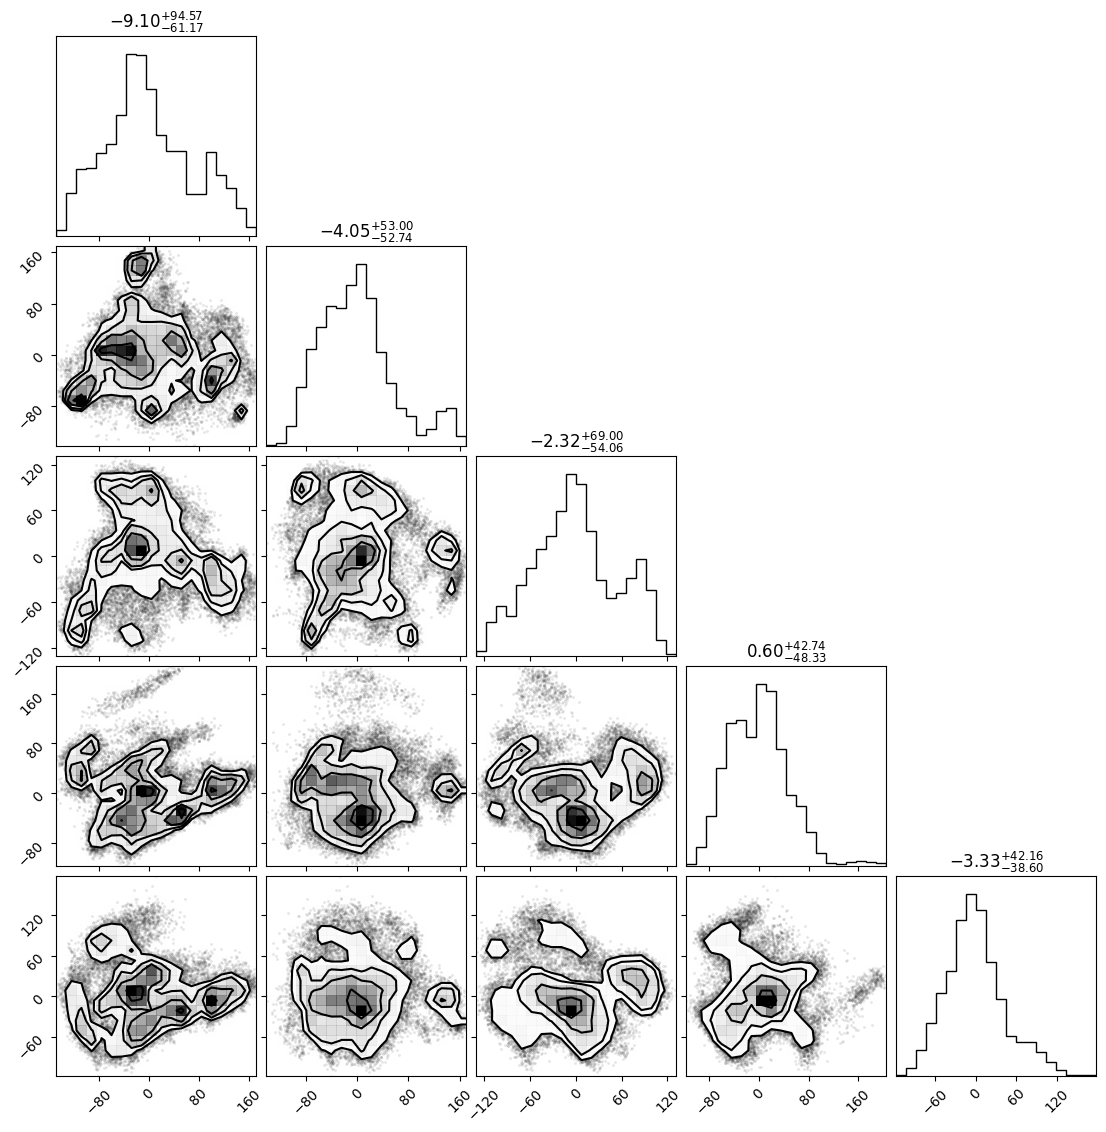

In [1]:
#code to import and plot the data
import pandas as pd
import matplotlib.pyplot as plt
import corner

column_names = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
data = pd.read_csv('../data/TM_projections.txt', sep='\s+', names=column_names, header=None)


fig = corner.corner(data, show_titles=True)
plt.show()

**Part 2: K-means clustering on the data**

Last time you probably found that clusters into 6 clusters gave the optimal silhoutte score, so cluster the data into 6 clusters, and plot the cluster populations, and the cluster number vs time.

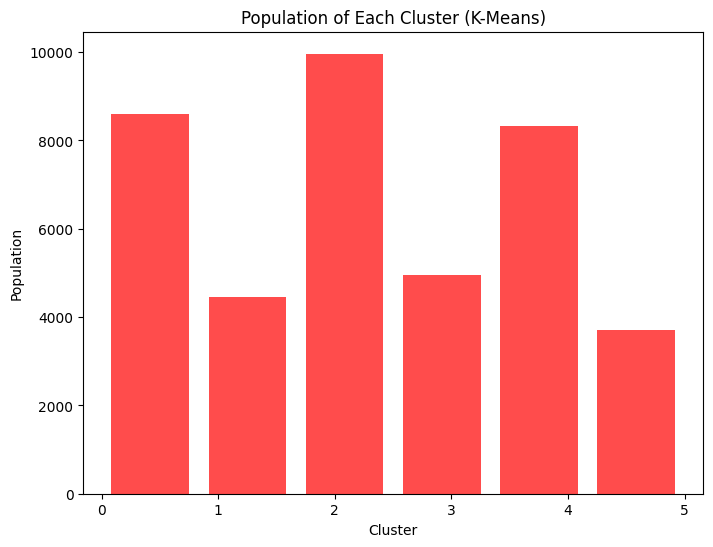

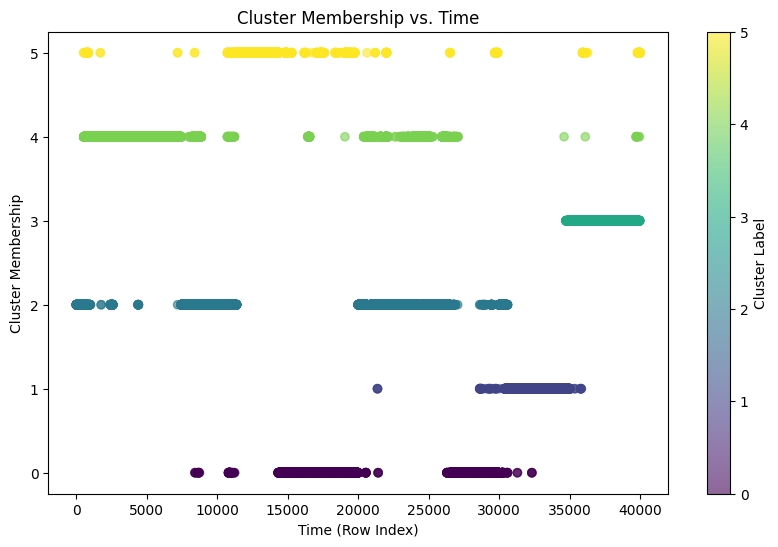

In [2]:
#code to kmeans cluster for 5D data
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=6, init='k-means++', random_state=42,n_init='auto')
kmeans.fit(data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])
cluster_labels = kmeans.predict(data[['PC1', 'PC2', 'PC3', 'PC4', 'PC5']])


# Plotting cluster populations in histogram 
plt.figure(figsize=(8, 6))
plt.hist(cluster_labels, bins=6, rwidth=0.8, color='red', alpha=0.7)
plt.title('Population of Each Cluster (K-Means)')
plt.xlabel('Cluster')
plt.ylabel('Population')
plt.show()



# Generate a scatter plot cluster membership over time
plt.figure(figsize=(10, 6))
plt.scatter(data.index, cluster_labels, c=cluster_labels, cmap='viridis', alpha=0.6)

# Customize the plot
plt.title('Cluster Membership vs. Time')
plt.xlabel('Time (Row Index)')
plt.ylabel('Cluster Membership')
plt.colorbar(label='Cluster Label')


Part 3: Constructing Markov Models

A Markov model consists of a Markov chain, which is used to calculate a transition matrix, aka a Markov Matrix.

Markov chain

A Markov chain is a mathematical system that undergoes transitions from one state to another, on a state space, with the probability of each next state depending only on the current state and not on the sequence of events that preceded it (memorylessness property). This stochastic model is characterized by its transition probabilities, which describe the likelihood of moving from one state to another in a single time step.

Markov Matrix

A Markov matrix, also known as a transition matrix, is a square matrix describing the probabilities of moving from one state to another in a Markov chain. Each cell (i, j) in the matrix represents the probability of transitioning from state i to state j, with all rows in the matrix summing to 1, since the sum of probabilities to move from any given state to all possible states (including itself) is 100%.


From that description, it should be clear that a time series of cluster numbers can be considered as a Markov chain. Each cluster is a state in this analysis and if we assume that transitions from one time point to the next do not depend on previous time-points, then it is Markovian. and so we have a Markov chain. We can then construct the transition matrix by literally counting how often in a time step, the system moves from one cluster to another, or stays put.

Question 1: A transition matrix must be square, but is it a symmetric matrix? Why or why not?

Now let's actually calculate the transition matrix from our Markov chain. Change names as appropriate.

In [3]:
import numpy as np


num_clusters = 6  # Assuming there are 6 clusters
transition_counts = np.zeros((num_clusters, num_clusters))

for (i, j) in zip(cluster_labels[:-1], cluster_labels[1:]):
    transition_counts[i, j] += 1

# View the transition counts matrix
print("Transition counts matrix:")
print(transition_counts)

total_sum = np.sum(transition_counts)

print("Total sum of elements in the transition matrix:", total_sum)

len(data)


Transition counts matrix:
[[8.314e+03 2.400e+01 1.060e+02 0.000e+00 3.600e+01 1.200e+02]
 [2.400e+01 4.358e+03 3.100e+01 3.500e+01 1.000e+00 0.000e+00]
 [1.050e+02 3.200e+01 9.409e+03 0.000e+00 3.640e+02 5.300e+01]
 [0.000e+00 3.400e+01 0.000e+00 4.906e+03 8.000e+00 1.500e+01]
 [3.400e+01 1.000e+00 3.660e+02 8.000e+00 7.892e+03 1.900e+01]
 [1.230e+02 0.000e+00 5.000e+01 1.400e+01 1.900e+01 3.498e+03]]
Total sum of elements in the transition matrix: 39999.0


40000

Question 2: Is the sum of the elements in the transition matrix correct? Why or why not?


How you need to normalize the matrix so that the probability of going from a state to all other states is 1. That simply enforces the idea that the state space is complete, so that the system doesn't disappear. 


In [4]:
transition_probabilities = transition_counts / transition_counts.sum(axis=1, keepdims=True)

# Handling cases where a row sums to 0 (no outgoing transitions) by setting probabilities to 0
transition_probabilities[np.isnan(transition_probabilities)] = 0

# View the transition probabilities matrix
print("Transition probabilities matrix:")
print(transition_probabilities)

total_sum = np.sum(transition_probabilities)

print("Total sum of elements in the transition matrix:", total_sum)


Transition probabilities matrix:
[[9.66744186e-01 2.79069767e-03 1.23255814e-02 0.00000000e+00
  4.18604651e-03 1.39534884e-02]
 [5.39447067e-03 9.79545965e-01 6.96785795e-03 7.86693639e-03
  2.24769611e-04 0.00000000e+00]
 [1.05389943e-02 3.21188397e-03 9.44394259e-01 0.00000000e+00
  3.65351802e-02 5.31968283e-03]
 [0.00000000e+00 6.85069514e-03 0.00000000e+00 9.88515011e-01
  1.61192827e-03 3.02236550e-03]
 [4.08653846e-03 1.20192308e-04 4.39903846e-02 9.61538462e-04
  9.48557692e-01 2.28365385e-03]
 [3.32073434e-02 0.00000000e+00 1.34989201e-02 3.77969762e-03
  5.12958963e-03 9.44384449e-01]]
Total sum of elements in the transition matrix: 6.0


Questions 3: Does the sum of the probabilities make sense? Why or why not?

It is often easier to see what the transition matrix looks like if we visualize it

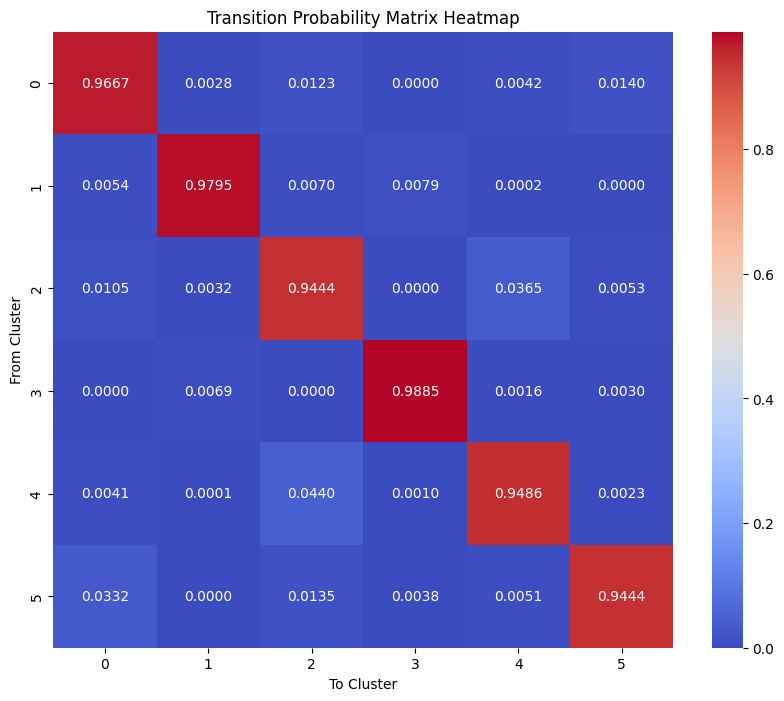

In [5]:
import seaborn as sns

# Assuming transition_probabilities is your transition matrix
plt.figure(figsize=(10, 8))  # Set the figure size for better readability
sns.heatmap(transition_probabilities, annot=True, cmap='coolwarm', fmt=".4f")
plt.title('Transition Probability Matrix Heatmap')
plt.xlabel('To Cluster')
plt.ylabel('From Cluster')
plt.show()



Questions 4: What is the most probable transition for each state in one timestep? Is it surprising?
What are the second most probable outcomes for each state in a timestep? 
Are all state to state transitions allowed? 
Finally, is the transition matrix symmetry? Does that make sense, why or why not.

Part 4: Evolving states with Markov models

Since we have a transition matrix, this means we can see what happens to a given initial state over time.
For example, if we start in cluster 0) we can see what happens over time to that state. That is what is the probability at a given time that a particular system that started in cluster 0 is in another state, or equivalently, if we had many systems that all started in cluster 0, what is fraction will be in a particular state at a particular time.

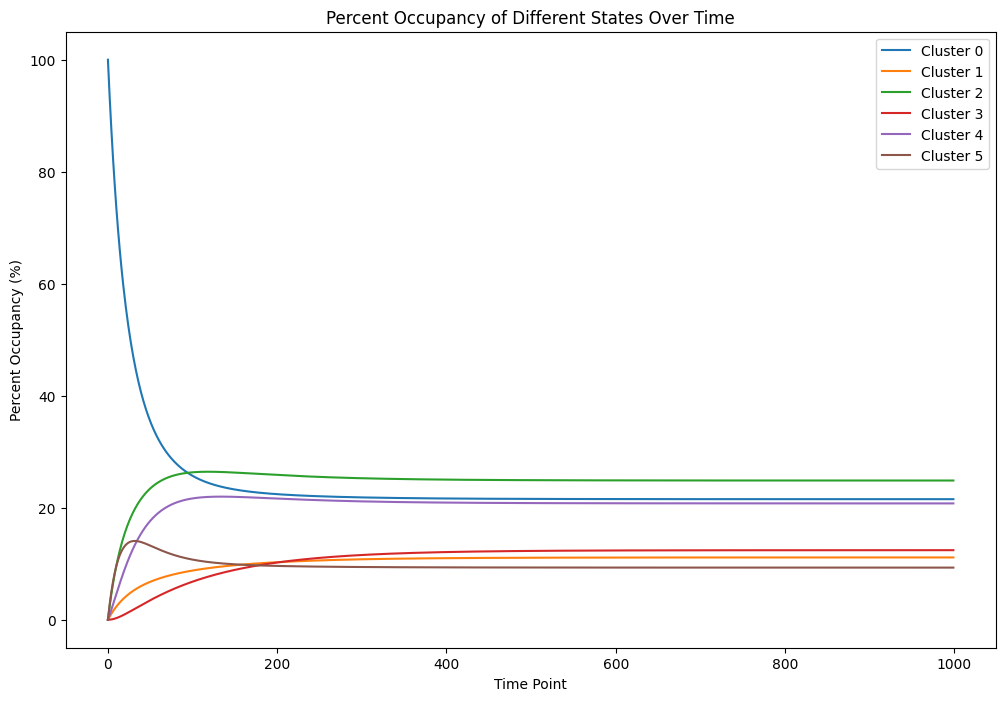

Final State Vector: [0.21526316 0.11121402 0.24856618 0.12418505 0.20771038 0.09306121]


In [57]:
# Specify the number of states and time points
num_states = 6
num_time_points = 1000

# Define an initial state vector
# Starting entirely in cluster 0
initial_state_0 = np.array([1, 0, 0, 0, 0, 0])

# Initialize an array to store state vectors over time
states_over_time= np.zeros((num_time_points, num_states))
states_over_time[0] = initial_state_0

# Calculate the state at each time point
for t in range(1, num_time_points):
    states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)

# Plot the percent occupancy of different clusters over time
plt.figure(figsize=(12, 8))
for i in range(num_states):
    plt.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')

plt.title('Percent Occupancy of Different States Over Time')
plt.xlabel('Time Point')
plt.ylabel('Percent Occupancy (%)')
plt.legend()
plt.show()

final_state_vector_0= states_over_time[-1]
print("Final State Vector:", final_state_vector_0)

Question 5: Discuss what happens to the different probabilities over time. Note, the changes are not necessarily monotonic. Change the number of time points as needed to make the behavior clear.

Exercise 1: What happens if we start in the other states? Change the name of the final state vector that is saved so we can make comparisions later. Make figures, and discuss the different temporal behaviors. Do they relax to the same set of probabilities? Do they do so in the same manner? 

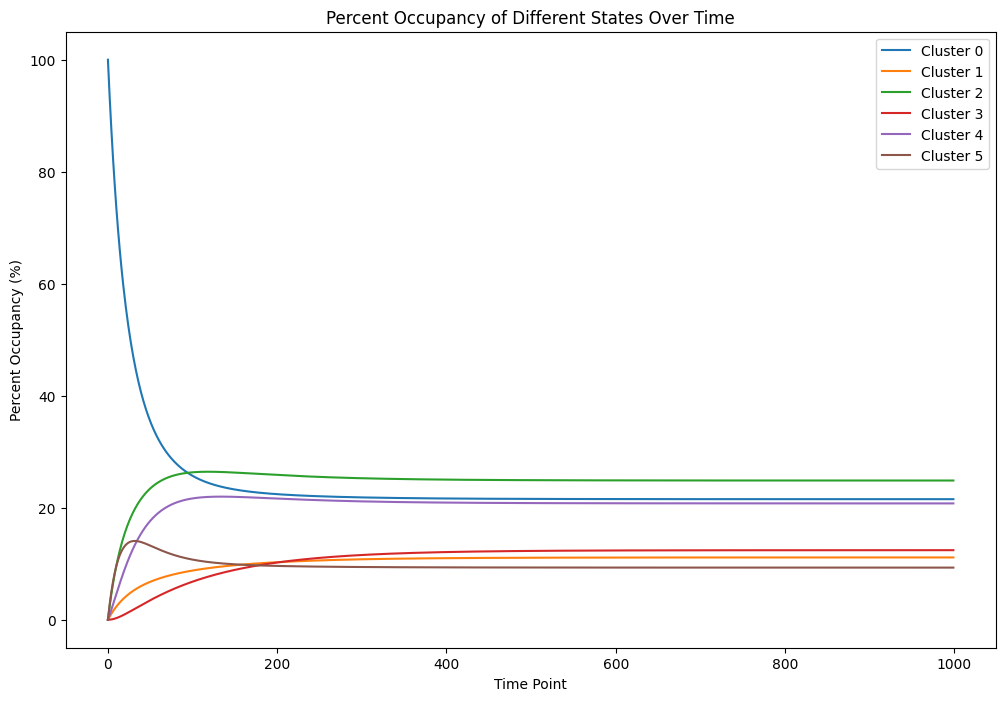

Final State Vector: [0.21526316 0.11121402 0.24856618 0.12418505 0.20771038 0.09306121]


In [58]:
num_states = 6
num_time_points = 1000

# Define an initial state vector
# Starting entirely in cluster 0
initial_state_0 = np.array([1, 0, 0, 0, 0, 0])

# Initialize an array to store state vectors over time
states_over_time= np.zeros((num_time_points, num_states))
states_over_time[0] = initial_state_0

# Calculate the state at each time point
for t in range(1, num_time_points):
    states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)

# Plot the percent occupancy of different clusters over time
plt.figure(figsize=(12, 8))
for i in range(num_states):
    plt.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')

plt.title('Percent Occupancy of Different States Over Time')
plt.xlabel('Time Point')
plt.ylabel('Percent Occupancy (%)')
plt.legend()
plt.show()

final_state_vector_0= states_over_time[-1]
print("Final State Vector:", final_state_vector_0)


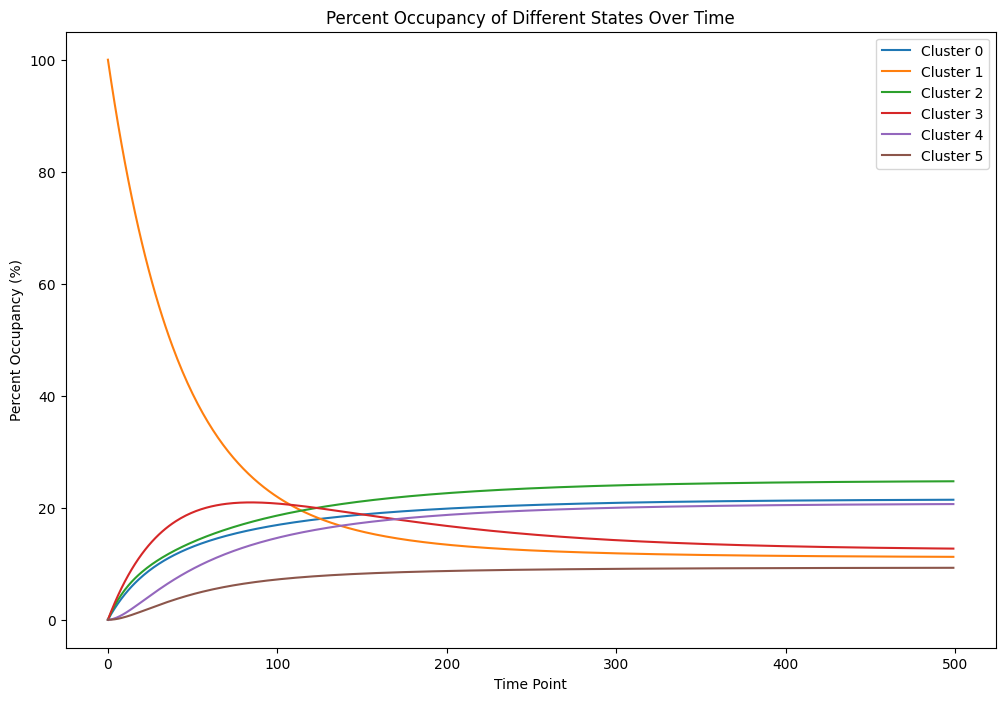

Final State Vector: [0.21424608 0.11229163 0.24722707 0.12699082 0.20651938 0.09272502]


In [37]:
num_states = 6
num_time_points = 500

# Define an initial state vector
# Starting entirely in cluster 0
initial_state_1 = np.array([0, 1, 0, 0, 0, 0])

# Initialize an array to store state vectors over time
states_over_time= np.zeros((num_time_points, num_states))
states_over_time[0] = initial_state_1

# Calculate the state at each time point
for t in range(1, num_time_points):
    states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)

# Plot the percent occupancy of different clusters over time
plt.figure(figsize=(12, 8))
for i in range(num_states):
    plt.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')

plt.title('Percent Occupancy of Different States Over Time')
plt.xlabel('Time Point')
plt.ylabel('Percent Occupancy (%)')
plt.legend()
plt.show()

final_state_vector_1= states_over_time[-1]
print("Final State Vector:", final_state_vector_1)

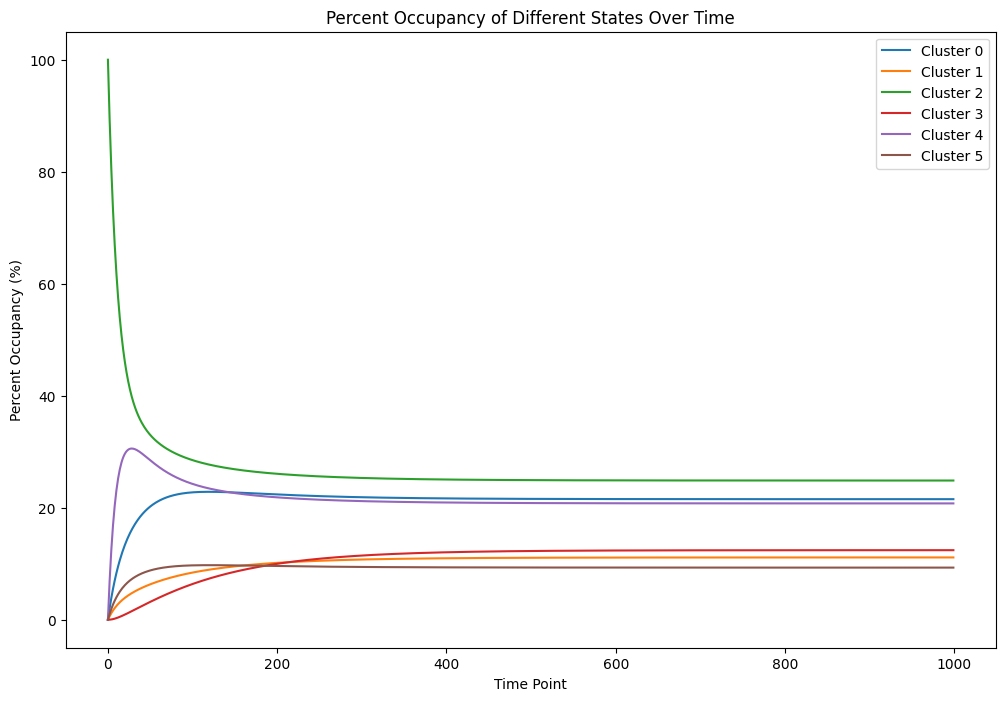

Final State Vector: [0.21526367 0.11121349 0.24856685 0.12418365 0.20771097 0.09306137]


In [59]:
num_states = 6
num_time_points = 1000

# Define an initial state vector
# Starting entirely in cluster 0
initial_state_2 = np.array([0, 0, 1, 0, 0, 0])

# Initialize an array to store state vectors over time
states_over_time= np.zeros((num_time_points, num_states))
states_over_time[0] = initial_state_2

# Calculate the state at each time point
for t in range(1, num_time_points):
    states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)

# Plot the percent occupancy of different clusters over time
plt.figure(figsize=(12, 8))
for i in range(num_states):
    plt.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')

plt.title('Percent Occupancy of Different States Over Time')
plt.xlabel('Time Point')
plt.ylabel('Percent Occupancy (%)')
plt.legend()
plt.show()

final_state_vector_2= states_over_time[-1]
print("Final State Vector:", final_state_vector_2)

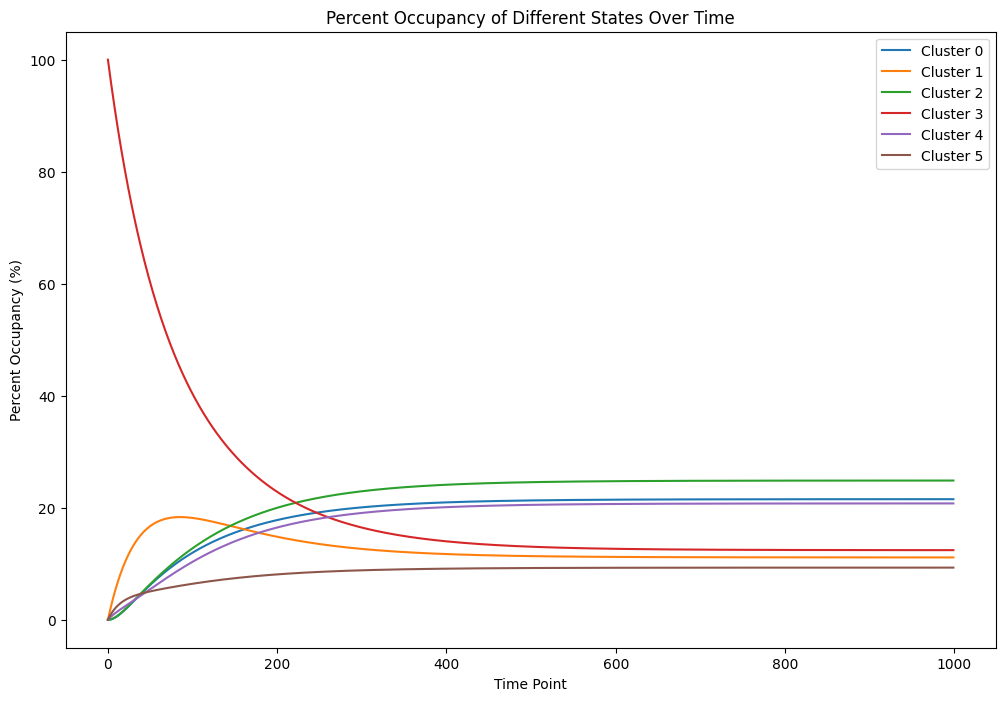

Final State Vector: [0.21523797 0.11124064 0.24853303 0.12425458 0.20768089 0.09305289]


In [60]:
num_states = 6
num_time_points = 1000

# Define an initial state vector
# Starting entirely in cluster 0
initial_state_3 = np.array([0, 0, 0, 1, 0, 0])

# Initialize an array to store state vectors over time
states_over_time= np.zeros((num_time_points, num_states))
states_over_time[0] = initial_state_3

# Calculate the state at each time point
for t in range(1, num_time_points):
    states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)

# Plot the percent occupancy of different clusters over time
plt.figure(figsize=(12, 8))
for i in range(num_states):
    plt.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')

plt.title('Percent Occupancy of Different States Over Time')
plt.xlabel('Time Point')
plt.ylabel('Percent Occupancy (%)')
plt.legend()
plt.show()

final_state_vector_3= states_over_time[-1]
print("Final State Vector:", final_state_vector_3)

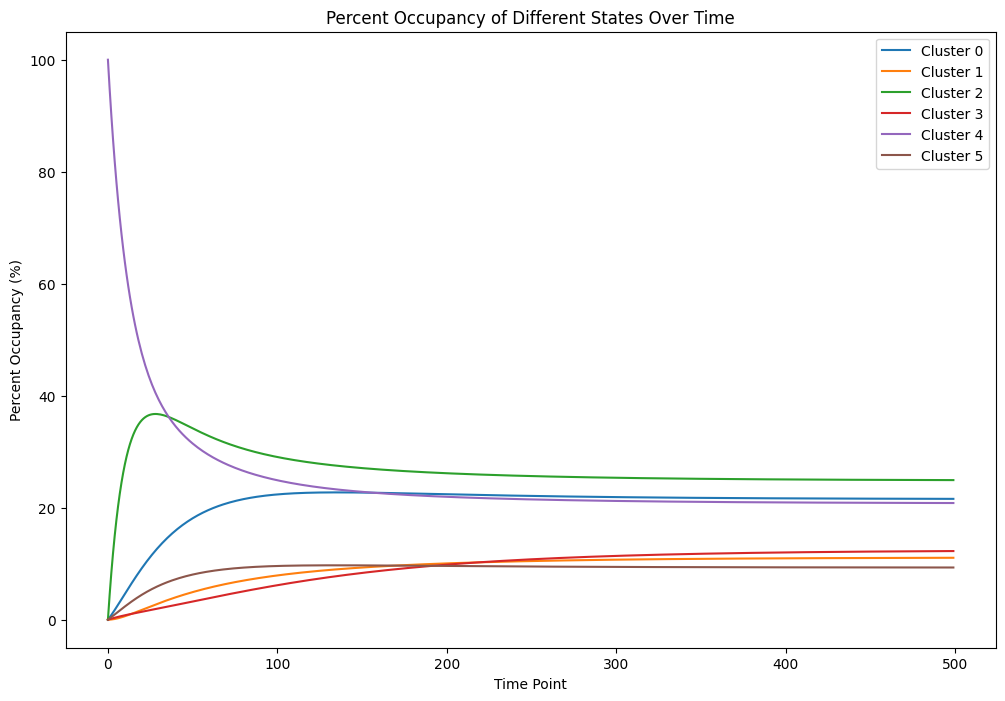

Final State Vector: [0.21583376 0.11061066 0.24931742 0.12261006 0.20837841 0.09324969]


In [41]:
num_states = 6
num_time_points = 500

# Define an initial state vector
# Starting entirely in cluster 0
initial_state_4 = np.array([0, 0, 0, 0, 1, 0])

# Initialize an array to store state vectors over time
states_over_time= np.zeros((num_time_points, num_states))
states_over_time[0] = initial_state_4

# Calculate the state at each time point
for t in range(1, num_time_points):
    states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)

# Plot the percent occupancy of different clusters over time
plt.figure(figsize=(12, 8))
for i in range(num_states):
    plt.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')

plt.title('Percent Occupancy of Different States Over Time')
plt.xlabel('Time Point')
plt.ylabel('Percent Occupancy (%)')
plt.legend()
plt.show()

final_state_vector_4= states_over_time[-1]
print("Final State Vector:", final_state_vector_4)

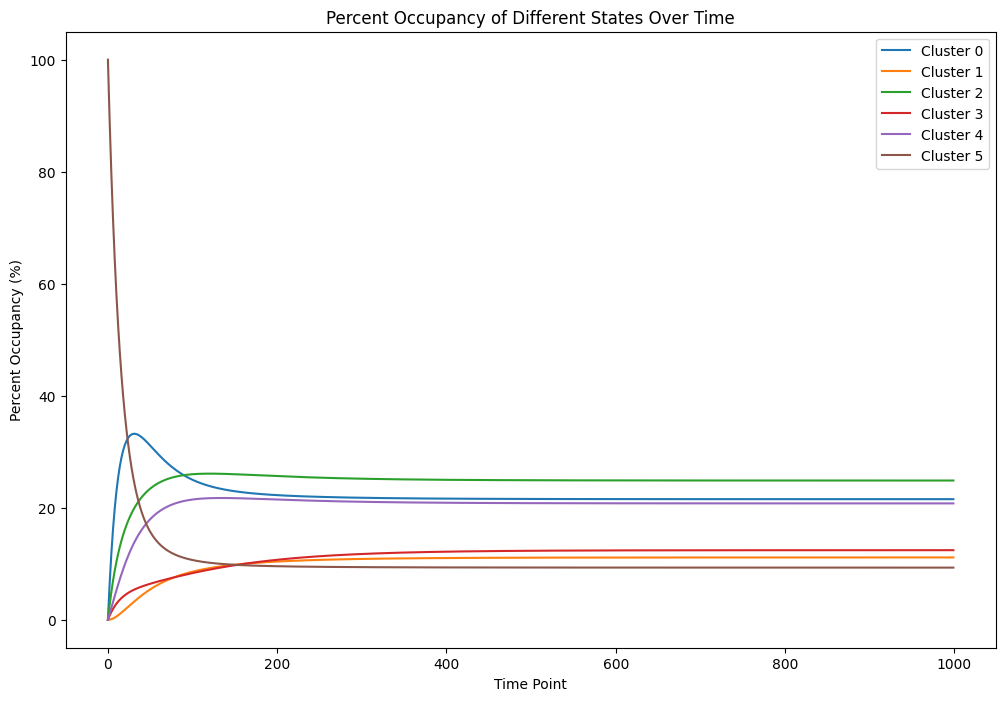

Final State Vector: [0.21526224 0.11121499 0.24856497 0.12418759 0.2077093  0.0930609 ]


In [61]:
num_states = 6
num_time_points = 1000

# Define an initial state vector
# Starting entirely in cluster 0
initial_state_5 = np.array([0, 0, 0, 0, 0, 1])

# Initialize an array to store state vectors over time
states_over_time= np.zeros((num_time_points, num_states))
states_over_time[0] = initial_state_5

# Calculate the state at each time point
for t in range(1, num_time_points):
    states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)

# Plot the percent occupancy of different clusters over time
plt.figure(figsize=(12, 8))
for i in range(num_states):
    plt.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')

plt.title('Percent Occupancy of Different States Over Time')
plt.xlabel('Time Point')
plt.ylabel('Percent Occupancy (%)')
plt.legend()
plt.show()

final_state_vector_5= states_over_time[-1]
print("Final State Vector:", final_state_vector_5)

Now let's see quantiatively if starting in the different states results in converging to the same final probability distribution and how well do they compare with the actual cluster distribution we used to get the Markov matrix. Change names as appopriate.

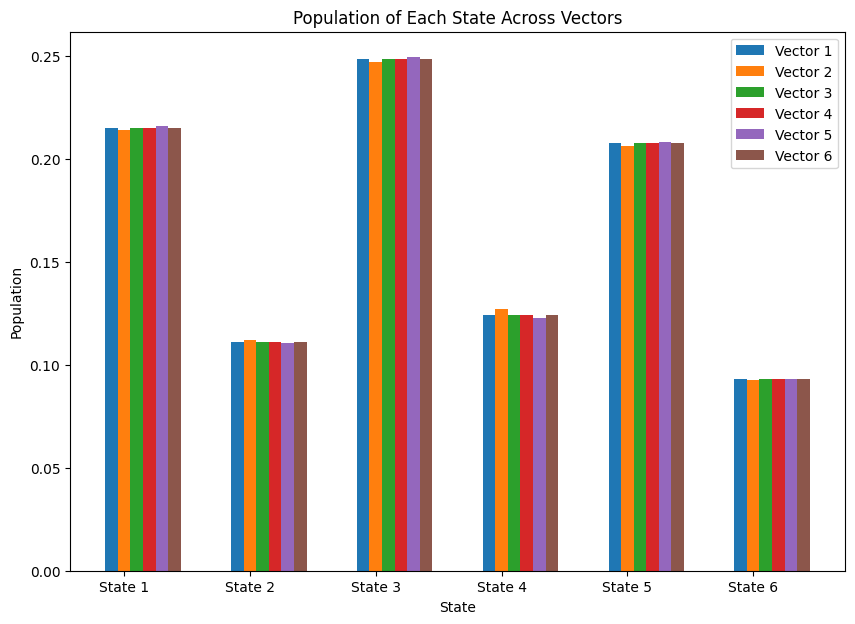

[[0.21526316 0.11121402 0.24856618 0.12418505 0.20771038 0.09306121]
 [0.21424608 0.11229163 0.24722707 0.12699082 0.20651938 0.09272502]
 [0.21526367 0.11121349 0.24856685 0.12418365 0.20771097 0.09306137]
 [0.21523797 0.11124064 0.24853303 0.12425458 0.20768089 0.09305289]
 [0.21583376 0.11061066 0.24931742 0.12261006 0.20837841 0.09324969]
 [0.21526224 0.11121499 0.24856497 0.12418759 0.2077093  0.0930609 ]]
Cluster Probabilities: [0.215    0.111225 0.249075 0.124075 0.208    0.092625]


In [62]:
# Collect all final state vectors into a matrix for easier plotting
final_state_vectors = np.array([
    final_state_vector_0,
    final_state_vector_1,
    final_state_vector_2,
    final_state_vector_3,
    final_state_vector_4,
    final_state_vector_5,
    
])

# Number of clusters/states
num_states = final_state_vector_0.shape[0]

# Setting up the plot
fig, ax = plt.subplots(figsize=(10, 7))
state_indices = range(num_states)
bar_width = 0.1  # Width of the bars

# Create a bar chart for each final state vector
for i in range(final_state_vectors.shape[0]):
    ax.bar(state_indices, final_state_vectors[i], bar_width, label=f'Vector {i+1}')
    state_indices = [x + bar_width for x in state_indices]  # Shift for the next vector

# Finalizing the plot
ax.set_xlabel('State')
ax.set_ylabel('Population')
ax.set_title('Population of Each State Across Vectors')
ax.set_xticks([r + bar_width for r in range(num_states)])
ax.set_xticklabels([f'State {i+1}' for i in range(num_states)])
ax.legend()

plt.show()
print(final_state_vectors) 
# Calculate the population of each cluster
clusters, counts = np.unique(cluster_labels, return_counts=True)

# Calculate the probabilities for each cluster by normalizing the counts
cluster_probabilities = counts / counts.sum()

# Save cluster probabilities
print("Cluster Probabilities:", cluster_probabilities)


You should that they do not converge to the same distribution. However, we only did 100 time points.

Exercise 2: Extend the number of time points until the final state vectors are virtually identical. What does this tell us? Discuss and comment.

Part 5: Quantiatively exploring convergence

In the previous part, you explored different initial conditions and convergences one at a time. Obviously, we could do it more efficiently. We could give it a number of initial conditions, and have the computer do all the plots, and calculate when convergences occurs to a given criteria, such as element-wise to within 1%

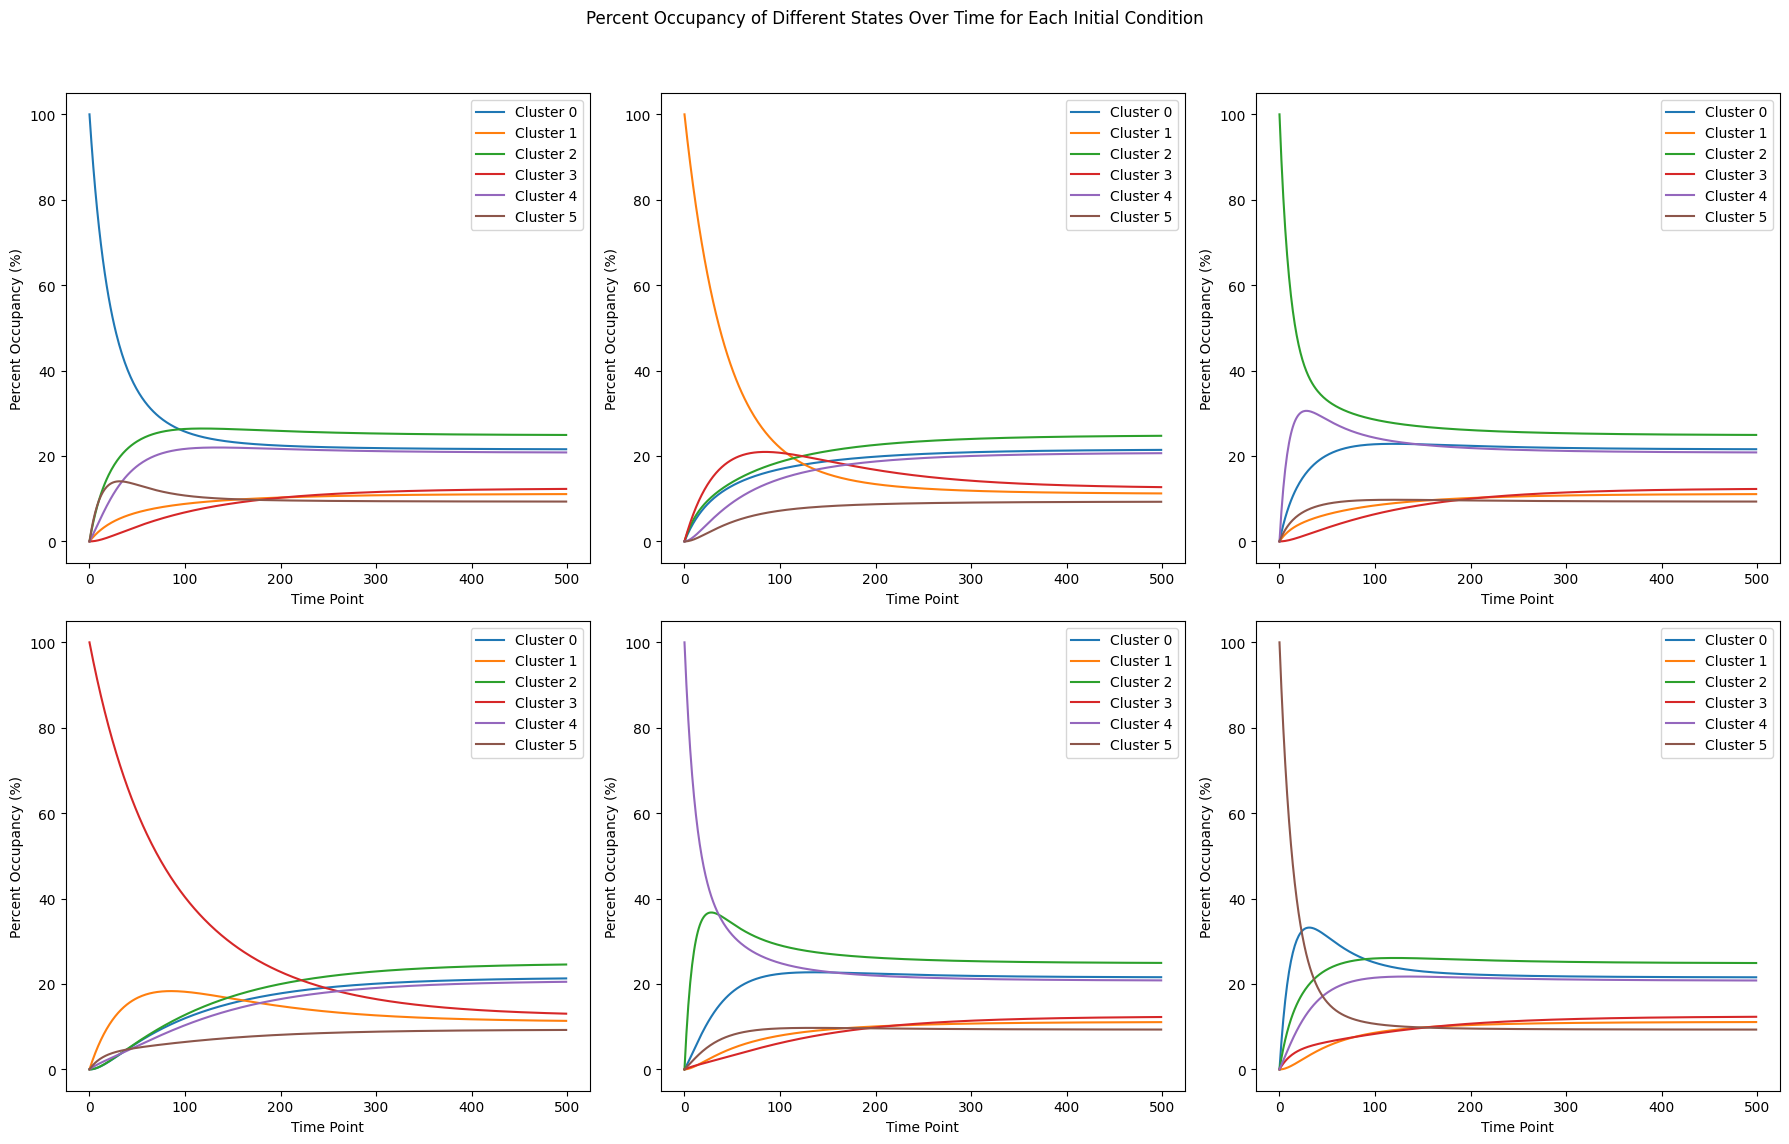

Initial Condition 0 converged at time point 283.
Initial Condition 1 converged at time point 364.
Initial Condition 2 converged at time point 295.
Initial Condition 3 converged at time point 450.
Initial Condition 4 converged at time point 302.
Initial Condition 5 converged at time point 258.


In [45]:

# Specify the number of states and time points
num_states = 6
num_time_points = 500



# Define a list of initial state vectors
initial_conditions = [
    np.array([1, 0, 0, 0, 0, 0]),
    np.array([0, 1, 0, 0, 0, 0]),
    np.array([0, 0, 1, 0, 0, 0]),
    np.array([0, 0, 0, 1, 0, 0]),
    np.array([0, 0, 0, 0, 1, 0]),
    np.array([0, 0, 0, 0, 0, 1])
    # Add more initial conditions as needed
]

# Create a figure to hold the subplots
fig, axs = plt.subplots(len(initial_conditions)//3, 3, figsize=(18, 12)) #modify as needed for initial conditions
fig.suptitle('Percent Occupancy of Different States Over Time for Each Initial Condition')

# Initialize a list to save convergence times for each initial condition
convergence_times = []

# Iterate through each provided initial condition
for idx, initial_state in enumerate(initial_conditions):
    states_over_time = np.zeros((num_time_points, num_states))
    states_over_time[0] = initial_state

    convergence_time_point = None  # Initialize to None for each initial condition

    # Calculate the state at each time point and check for convergence
    for t in range(1, num_time_points):
        states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)
        if convergence_time_point is None and np.allclose(states_over_time[t], cluster_probabilities, atol=0.01):
            convergence_time_point = t

    convergence_times.append(convergence_time_point)  # Save convergence time

    # Plotting for the current initial condition
    ax = axs[idx // 3, idx % 3 ] #modify as needed for initial conditions
    for i in range(num_states):
        ax.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')
    
    ax.set_xlabel('Time Point')
    ax.set_ylabel('Percent Occupancy (%)')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print out convergence times for each initial condition
for i, time in enumerate(convergence_times):
    if time is not None:
        print(f"Initial Condition {i} converged at time point {time}.")
    else:
        print(f"Initial Condition {i} did not converge within the specified time points.")


Now, we will explore different initial conditions. We have done all the ones where there is 100% probability to start in a particular state (aka cluster), these are call pure states. However, mixed states are possible such as [0,0,0.8, 0.0, 0.0, 0.0, 0.2], this means either there is an 80% chance of starting in cluster 1 (remember cluster numbering starts at 1), and a 20% change of starting in cluster 5, or that there are many copies of this system and 80% start in cluster 1 and 20% in cluster 5.

Exercise 3: Explore a number of different mixed states ( at least 18) and see what happens. Note, there are two lines you will have to modify if you don't do a multiple of 3.

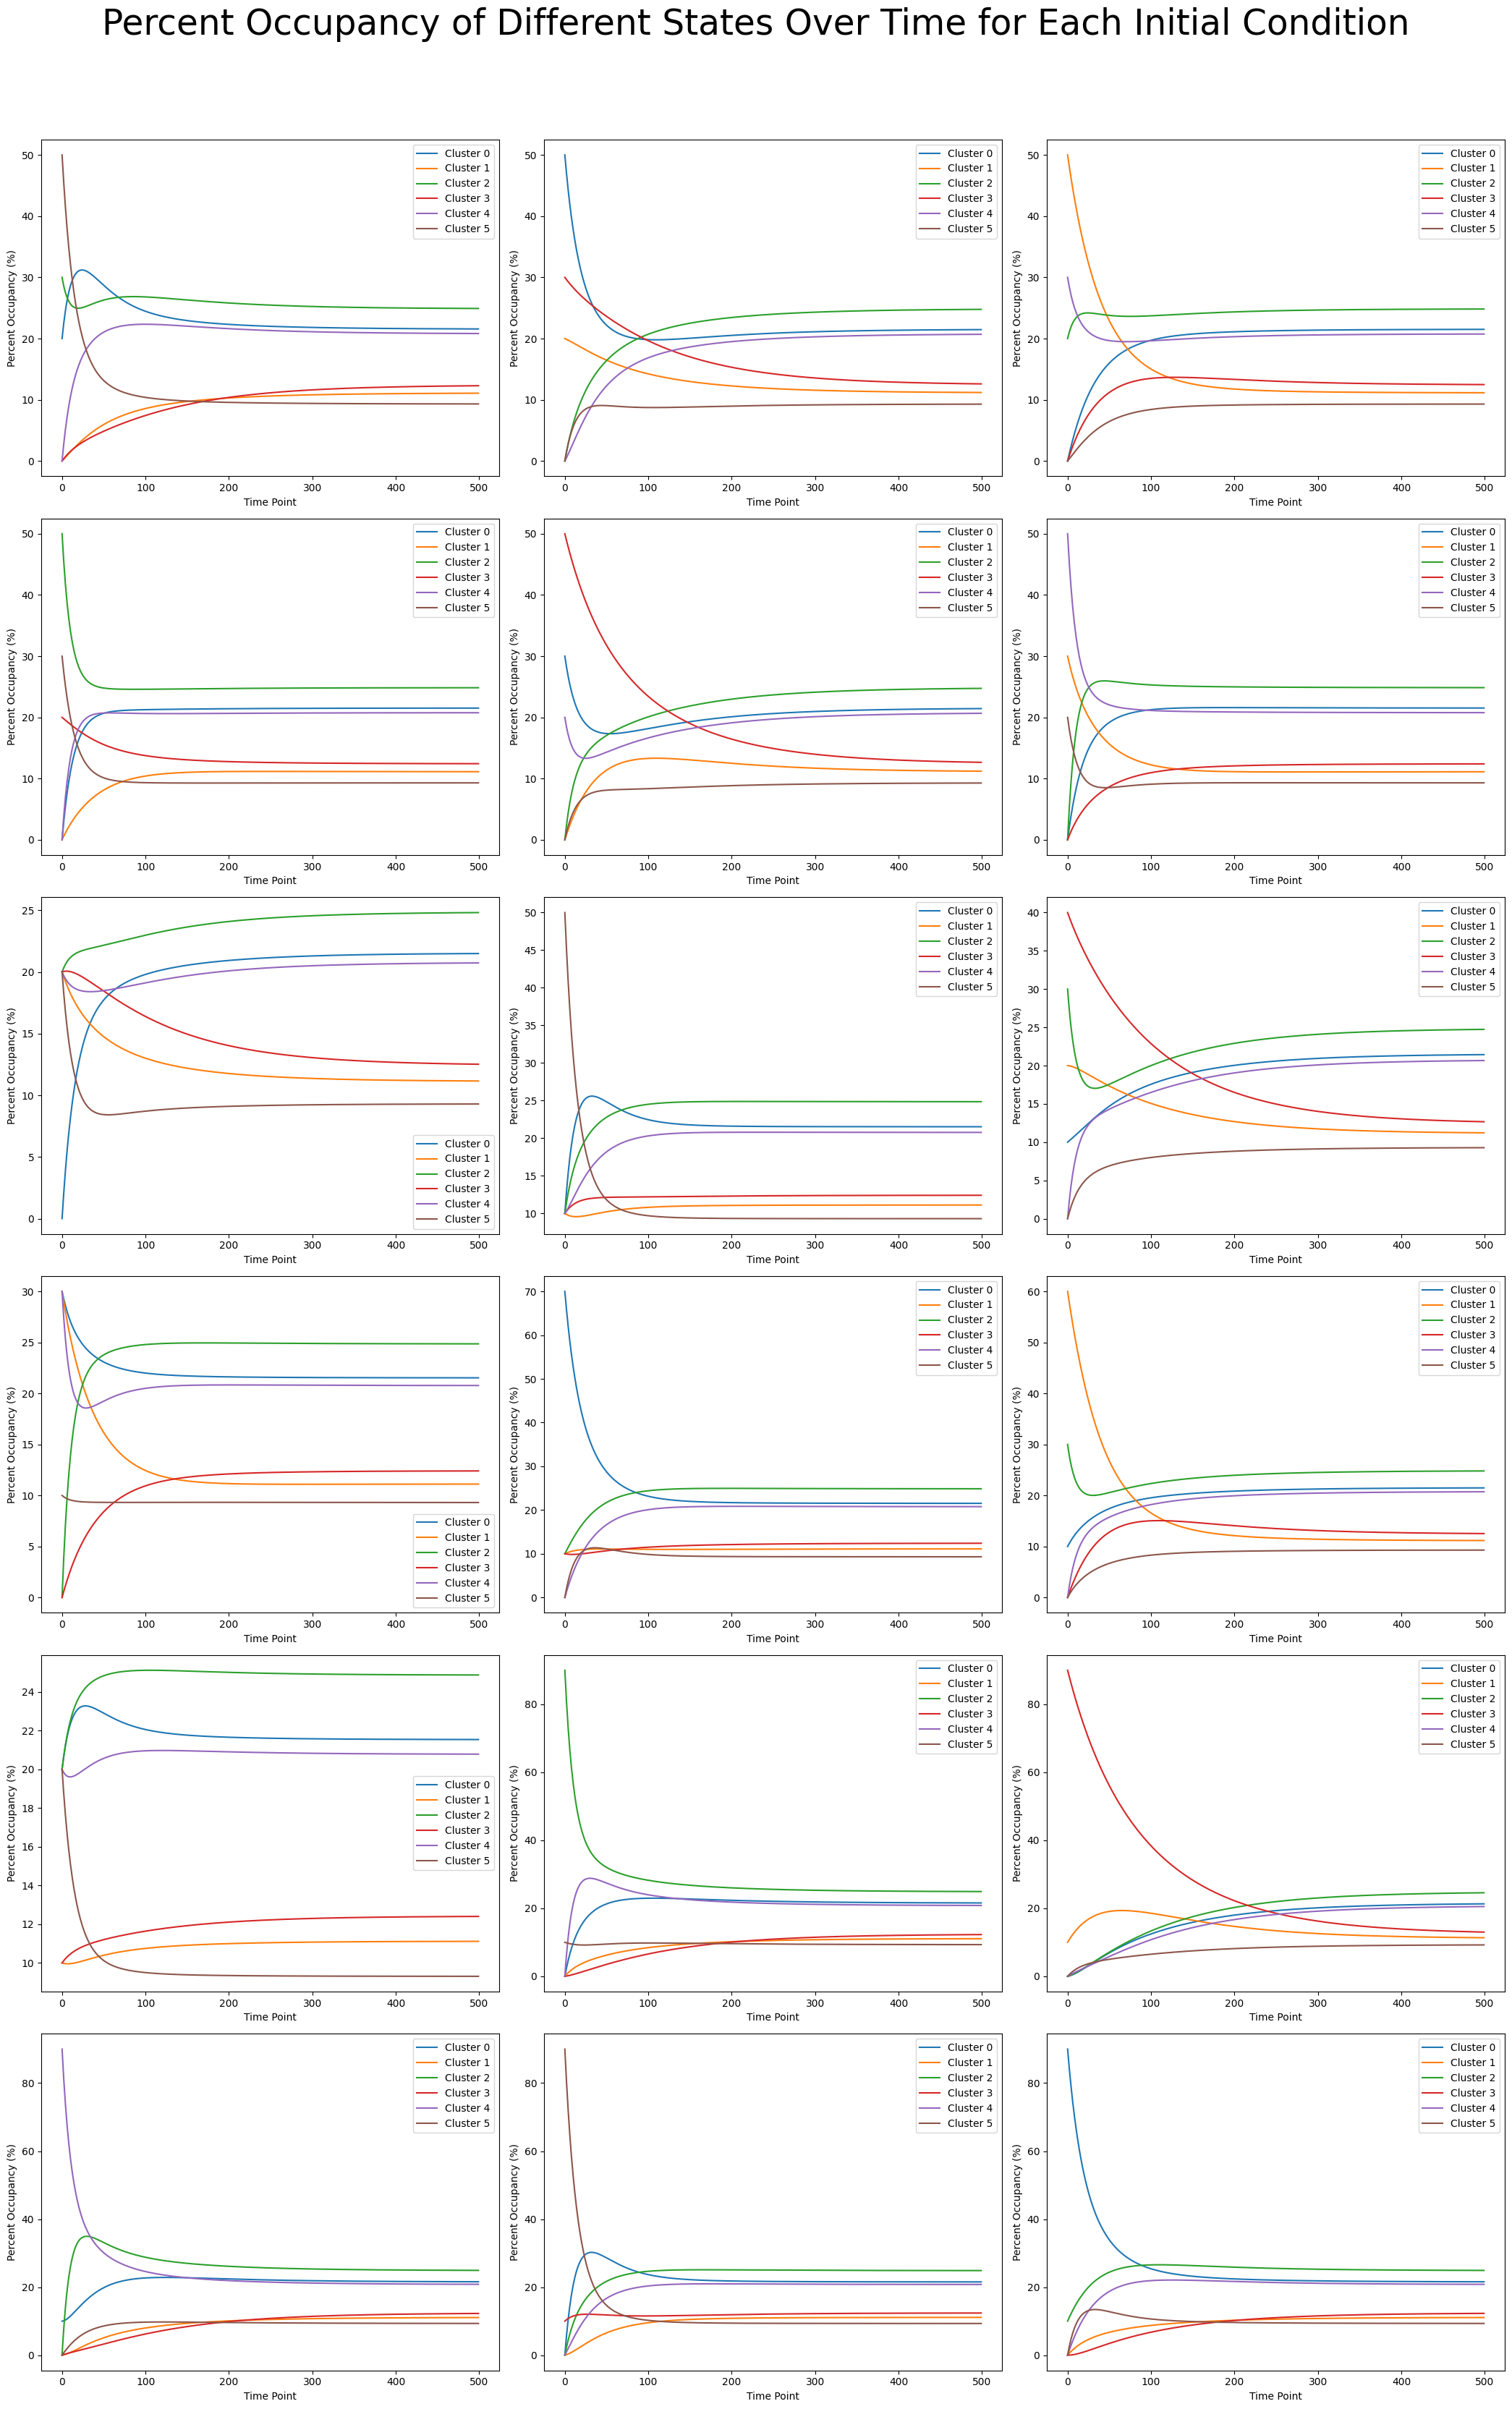

Initial Condition 0 converged at time point 275.
Initial Condition 1 converged at time point 315.
Initial Condition 2 converged at time point 187.
Initial Condition 3 converged at time point 120.
Initial Condition 4 converged at time point 349.
Initial Condition 5 converged at time point 122.
Initial Condition 6 converged at time point 253.
Initial Condition 7 converged at time point 99.
Initial Condition 8 converged at time point 352.
Initial Condition 9 converged at time point 121.
Initial Condition 10 converged at time point 120.
Initial Condition 11 converged at time point 261.
Initial Condition 12 converged at time point 71.
Initial Condition 13 converged at time point 291.
Initial Condition 14 converged at time point 444.
Initial Condition 15 converged at time point 300.
Initial Condition 16 converged at time point 134.
Initial Condition 17 converged at time point 284.


In [55]:
# Secify the number of states and time points
num_states = 6
num_time_points = 500



# Define a list of initial state vectors
#Mixed State 1
initial_conditions = [
    np.array([0.2, 0, 0.3, 0, 0, .5]),
    np.array([.5, 0.2, 0, 0.3, 0, 0]),
    np.array([0, .5, 0.2, 0, 0.3, 0]),
    np.array([0,0,.5,0.2,0,0.3]),
    np.array([0.3,0,0,.5,.2,0]),
    np.array([0, 0.3, 0, 0, .5, .2]),
    np.array([0,.2,.2,.2,.2,.2]),
    np.array([.1,.1,.1,.1,.1,.5]),
    np.array([.1,.2,.3,.4,0,0]),
    np.array([.3,.3,0,0,.3,.1]),
    np.array([.7,.1,.1,.1,0,0]),
    np.array([.1,.6,.3,0,0,0]),
    np.array([.2,.1,.2,.1,.2,.2]),
    np.array([0, 0, .9, 0, 0, .1]),
    np.array([0, .1, 0, .9, 0, 0]),
    np.array([.1, 0, 0, 0, .9, 0]),
    np.array([0, 0, 0, .1, 0, .9]),
    np.array([.9,0,.1,0,0,0])
    # Add more initial conditions as needed
]

# Create a figure to hold the subplots
fig, axs = plt.subplots(len(initial_conditions)//3, 3, figsize=(21, 35)) #modify as needed for initial conditions
fig.suptitle('Percent Occupancy of Different States Over Time for Each Initial Condition', fontsize = 35)

# Initialize a list to save convergence times for each initial condition
convergence_times = []

# Iterate through each provided initial condition
for idx, initial_state in enumerate(initial_conditions):
    states_over_time = np.zeros((num_time_points, num_states))
    states_over_time[0] = initial_state

    convergence_time_point = None  # Initialize to None for each initial condition

    # Calculate the state at each time point and check for convergence
    for t in range(1, num_time_points):
        states_over_time[t] = states_over_time[t-1].dot(transition_probabilities)
        if convergence_time_point is None and np.allclose(states_over_time[t], cluster_probabilities, atol=0.01):
            convergence_time_point = t

    convergence_times.append(convergence_time_point)  # Save convergence time

    # Plotting for the current initial condition
    ax = axs[idx // 3, idx % 3 ] #modify as needed for initial conditions
    for i in range(num_states):
        ax.plot(states_over_time[:, i] * 100, label=f'Cluster {i}')
    
    ax.set_xlabel('Time Point')
    ax.set_ylabel('Percent Occupancy (%)')
    ax.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print out convergence times for each initial condition
for i, time in enumerate(convergence_times):
    if time is not None:
        print(f"Initial Condition {i} converged at time point {time}.")
    else:
        print(f"Initial Condition {i} did not converge within the specified time points.")